In [1]:
pip install gymnasium tqdm

Note: you may need to restart the kernel to use updated packages.


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import sys

In [55]:
# Neural Net
class NN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)  # Input layer
        self.layer2 = nn.Linear(128, 128)  # Hidden layer
        self.layer3 = nn.Linear(128, n_actions)  # Output layer

    def forward(self, x):
        x = F.relu(self.layer1(x))  # Activation function for the first layer
        x = F.relu(self.layer2(x))  # Activation function for the second layer
        x = F.dropout(x, p=0.5)  # Dropout regularization
        x = self.layer3(x)  # Output layer
        return F.softmax(x, dim=-1)

In [56]:
def compute_returns(rewards, discount_factor):
    returns = []
    G = 0

    for g in rewards:
        G = g + G * discount_factor  # Discounted return calculation
        returns.insert(0, G)  # Prepend the discounted return 
    returns = torch.tensor(returns)

    return returns

In [57]:
def optimize(returns, log_prob_actions, optimizer):
    
    loss = - (returns * log_prob_actions).sum()  # Policy gradient loss calculation

    optimizer.zero_grad()

    loss.backward()  # Backpropagation

    optimizer.step()  # Parameter update

    return loss.item()

In [58]:
n_observations = train_env.observation_space.shape[0]
n_actions = train_env.action_space.n

policy_net = NN(n_observations, n_actions)
policy_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

gamma = 0.99  # Discount factor
num_episodes = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make('CartPole-v1')
episodes = []
train_rewards = []

for episode in range(1, num_episodes+1):
    
    log_prob_actions = []
    rewards = []
    done = False
    episode_reward = 0

    state, _ = env.reset()

    for i in range(1000):
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        action_prob = policy_net(state)

        dist = distributions.Categorical(action_prob)  # Categorical distribution over actions

        action = dist.sample()  # Sample an action from the distribution

        log_prob_action = dist.log_prob(action)  # Log probability of the sampled action

        state, reward, terminated, truncated, _ = env.step(action.item())  # Take the action in the environment
        done = terminated or truncated
        log_prob_actions.append(log_prob_action)
        rewards.append(reward)

        episode_reward += reward
        if done:
            break

    log_prob_actions = torch.cat(log_prob_actions)

    returns = compute_returns(rewards, gamma)  # Compute the returns

    loss = optimize(returns, log_prob_actions, optimizer)  # Update the policy network

    train_reward = episode_reward

    episodes.append(episode)
    train_rewards.append(train_reward)

#     print('episode: ', episode)
#     print('train reward: ', train_reward)
#     print()

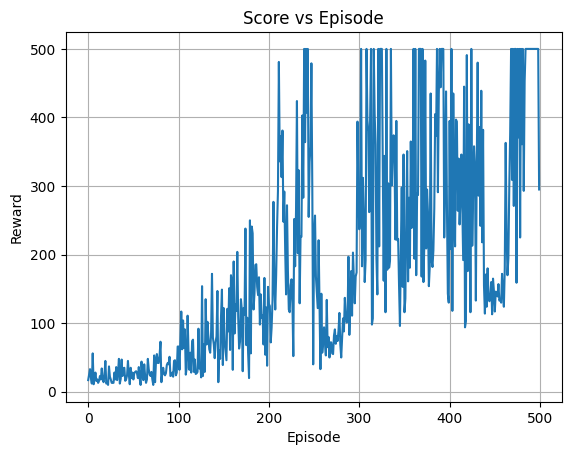

In [59]:
plt.plot(train_rewards, label='Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Score vs Episode')
plt.grid()
plt.show()